# TUTORIAL 01 : CAISO OASIS Renewables

## Goal

**Your mission, should you choose to accept it, is to replicate the following two
graphs from the [CAISO Renewables Reporting page](http://www.caiso.com/market/Pages/ReportsBulletins/RenewablesReporting.aspx_).**

## Example

![Renewables Reporting First Page](./resources/images/renewables-pdf-first-page.png)

### Setup

In [20]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil import parser
from pandasql import PandaSQL
pdf = PandaSQL('sqlite:///:memory:', persist=True)

# make graphs look modern and pretty
import seaborn as sns
sns.set()

# make tables look pretty
# (cribbed from Brandon Rhodes' tutorials)
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

### Problem 01: Replicate the 24-Hour Renewables Production Report

_Monday, October 28, 2019_

![24 Hour Production](./resources/images/renewables-01-24-hour-production.png)


* [ ] Find the data for this report
* [ ] Create dataframe with this report data
* [ ] Query for this particular day
* [ ] Query for the subtotals
* [ ] Display a plot that looks similar to the graph above

<span style="background-color:orange;color:blue">
#### Answer : Find the data for this report

Download the dataset

    curl -O https://s3.us-west-1.wasabisys.com/eap/energy-dashboard/data/data-oasis-daily-renewables-output/db/data-oasis-daily-renewables-output_00.db.gz
    
Unzip

    gunzip data-oasis-daily-renewables-output_00.db.gz

Verify the database

    sqlite3 data-oasis-daily-renewables-output_00.db
    > .tables
    > select count(*) from renewable;
    > select count(*) from total;
</span>

<span style="background-color:orange;color:blue">
#### Answer : Create dataframe with this report data
</span>

In [21]:
# create the connection to the unzipped database in this directory
cnx = sqlite3.connect(r'./data-oasis-daily-renewables-output_00.db')

# df1 : renewable(s) table
df1 = pd.read_sql("select * from renewable", cnx)
# df1a : total(s) table
df1a = pd.read_sql("select * from total", cnx)

In [22]:
# Examine the table and verify the dtypes
# ...especially the 'date' column
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83442 entries, 0 to 83441
Data columns (total 11 columns):
id               0 non-null object
date             83442 non-null object
hour             83442 non-null int64
geothermal       83402 non-null float64
biomass          83402 non-null float64
biogas           83401 non-null float64
small_hydro      83399 non-null float64
wind_total       83374 non-null float64
solar_pv         60631 non-null float64
solar_thermal    60631 non-null float64
solar            22744 non-null float64
dtypes: float64(8), int64(1), object(2)
memory usage: 7.0+ MB


In [23]:
# Examine the table and verify the dtypes
# ...especially the 'date' column
df1a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83447 entries, 0 to 83446
Data columns (total 8 columns):
id            0 non-null object
date          83447 non-null object
hour          83447 non-null int64
renewables    83397 non-null float64
nuclear       83422 non-null float64
thermal       83380 non-null float64
imports       83419 non-null float64
hydro         83407 non-null float64
dtypes: float64(5), int64(1), object(2)
memory usage: 5.1+ MB


In [24]:
# The magic of merge. It does the join intelligently for us. Kinda scary, really.
df2 = df1.merge(df1a)
df2.head()

,id,date,hour,geothermal,biomass,biogas,small_hydro,wind_total,solar_pv,solar_thermal,solar,renewables,nuclear,thermal,imports,hydro
0,None,2011-05-30 00:00:00,1,960.0,367.0,155.0,510.0,1873.0,NaN,NaN,0.0,3864.0,3432.0,3225.0,6770.0,3678.0
1,None,2011-05-30 00:00:00,2,792.0,370.0,154.0,510.0,1965.0,NaN,NaN,0.0,3792.0,3433.0,3207.0,6336.0,3405.0
2,None,2011-05-30 00:00:00,3,771.0,368.0,154.0,509.0,1784.0,NaN,NaN,0.0,3586.0,3433.0,3244.0,5866.0,3534.0
3,None,2011-05-30 00:00:00,4,890.0,369.0,154.0,509.0,1627.0,NaN,NaN,0.0,3550.0,3433.0,3233.0,5660.0,3546.0
4,None,2011-05-30 00:00:00,5,996.0,373.0,154.0,510.0,1354.0,NaN,NaN,0.0,3387.0,3436.0,2886.0,5751.0,4044.0


In [25]:
# Looks like we have merged correctly and basically appended the 'total' dataframe to the 'renewable' dataframe
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83441 entries, 0 to 83440
Data columns (total 16 columns):
id               0 non-null object
date             83441 non-null object
hour             83441 non-null int64
geothermal       83401 non-null float64
biomass          83401 non-null float64
biogas           83401 non-null float64
small_hydro      83398 non-null float64
wind_total       83374 non-null float64
solar_pv         60631 non-null float64
solar_thermal    60631 non-null float64
solar            22743 non-null float64
renewables       83391 non-null float64
nuclear          83416 non-null float64
thermal          83374 non-null float64
imports          83413 non-null float64
hydro            83401 non-null float64
dtypes: float64(13), int64(1), object(2)
memory usage: 10.8+ MB


In [26]:
# Sanitize the dataframe by converting the 'date' column to a datetime, 
# drop the useless 'id' column, and replace NaN|None values with zeros.
# Q: Why do we have NULL values? B/C the original downloaded data feeds
# had data errors splattered within the data files. 
df2['date'] = pd.to_datetime(df2['date'], infer_datetime_format=True)
df2.pop('id')
df2.fillna(0, inplace=True)

In [27]:
# Create a multi-index and experience the glory of time-series data!
df3 = df2.set_index(['date', 'hour'])
df3.head()

geothermal  biomass  biogas  small_hydro  wind_total  \
date       hour                                                         
2011-05-30 1          960.0    367.0   155.0        510.0      1873.0   
           2          792.0    370.0   154.0        510.0      1965.0   
           3          771.0    368.0   154.0        509.0      1784.0   
           4          890.0    369.0   154.0        509.0      1627.0   
           5          996.0    373.0   154.0        510.0      1354.0   

                 solar_pv  solar_thermal  solar  renewables  nuclear  thermal  \
date       hour                                                                 
2011-05-30 1          0.0            0.0    0.0      3864.0   3432.0   3225.0   
           2          0.0            0.0    0.0      3792.0   3433.0   3207.0   
           3          0.0            0.0    0.0      3586.0   3433.0   3244.0   
           4          0.0            0.0    0.0      3550.0   3433.0   3233.0   
           5          0.0            0.0    0.0      3387.0   3436.0   2886.0   

                 imports   hydro  
date       hour                   
2011-05-30 1      6770.0  3678.0  
           2      6336.0  3405.0  
           3      5866.0  3534.0  
           4      5660.0  3546.0  
           5      5751.0  4044.0

In [28]:
# Notice that the index is a DatetimeIndex with ~ 83K entries
df3.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 83441 entries, (2011-05-30 00:00:00, 1) to (2012-06-22 00:00:00, 24)
Data columns (total 13 columns):
geothermal       83441 non-null float64
biomass          83441 non-null float64
biogas           83441 non-null float64
small_hydro      83441 non-null float64
wind_total       83441 non-null float64
solar_pv         83441 non-null float64
solar_thermal    83441 non-null float64
solar            83441 non-null float64
renewables       83441 non-null float64
nuclear          83441 non-null float64
thermal          83441 non-null float64
imports          83441 non-null float64
hydro            83441 non-null float64
dtypes: float64(13)
memory usage: 8.5 MB


In [29]:
# Notice that the date range in the DatetimeIndex goes from 2011 to 2012??? We *should*
# have data up to today (2019)...
df3.tail()

geothermal  biomass  biogas  small_hydro  wind_total  \
date       hour                                                         
2012-06-22 20         919.0    320.0   198.0        424.0      2564.0   
           21         920.0    320.0   198.0        430.0      2584.0   
           22         921.0    310.0   199.0        421.0      2703.0   
           23         922.0    287.0   200.0        408.0      2428.0   
           24         925.0    280.0   198.0        395.0      2257.0   

                 solar_pv  solar_thermal  solar  renewables  nuclear  thermal  \
date       hour                                                                 
2012-06-22 20         0.0            0.0  195.0      4620.0   2263.0  10843.0   
           21         0.0            0.0  173.0      4626.0   2265.0  11225.0   
           22         0.0            0.0  158.0      4713.0   2265.0  10987.0   
           23         0.0            0.0   58.0      4302.0   2265.0   9174.0   
           24         0.0            0.0    0.0      4055.0   2265.0   7577.0   

                 imports   hydro  
date       hour                   
2012-06-22 20     8584.0  3222.0  
           21     8516.0  3230.0  
           22     8855.0  2815.0  
           23     9776.0  2503.0  
           24     9981.0  2137.0

In [30]:
# Could this be a sorting issue?

In [31]:
df4 = df3.sort_index()
df4.tail()

geothermal  biomass  biogas  small_hydro  wind_total  \
date       hour                                                         
2019-10-30 20         268.0    314.0   218.0        202.0       586.0   
           21         268.0    285.0   211.0        192.0       538.0   
           22         268.0    284.0   215.0        193.0       485.0   
           23         268.0    276.0   227.0        194.0       486.0   
           24         267.0    270.0   233.0        174.0       427.0   

                 solar_pv  solar_thermal  solar  renewables  nuclear  thermal  \
date       hour                                                                 
2019-10-30 20         0.0            0.0    0.0      1588.0   1120.0  16004.0   
           21         0.0            0.0    0.0      1494.0   1121.0  15196.0   
           22         0.0            0.0    0.0      1445.0   1121.0  14578.0   
           23         0.0            0.0    0.0      1451.0   1122.0  13373.0   
           24         0.0            0.0    0.0      1371.0   1121.0  12330.0   

                 imports   hydro  
date       hour                   
2019-10-30 20     6400.0  2094.0  
           21     6574.0  2079.0  
           22     6137.0  2076.0  
           23     5592.0  2070.0  
           24     5056.0  2068.0

In [32]:
# Ahhhh, so it was a sorting issue. 
# Note to self: remember to sort your indexes.

In [33]:
# I've currently downloaded through Oct 31, 2019 (or therabouts), so this seems close enough
len(df4.loc['2019'].index.unique())/24

303.0

<span style="background-color:orange;color:blue">
#### Answer : Query for this particular day
</span>

In [34]:
# We are graphing a particular date, so filter a DF accordingly
df5 = df4.loc['2019-10-28']
df5.head()

geothermal  biomass  biogas  small_hydro  wind_total  \
date       hour                                                         
2019-10-28 1          267.0    280.0   207.0        172.0      2564.0   
           2          267.0    276.0   206.0        172.0      2251.0   
           3          266.0    272.0   206.0        171.0      1824.0   
           4          267.0    274.0   206.0        172.0      1428.0   
           5          267.0    280.0   205.0        171.0      1140.0   

                 solar_pv  solar_thermal  solar  renewables  nuclear  thermal  \
date       hour                                                                 
2019-10-28 1          0.0            0.0    0.0      3490.0   1127.0   6956.0   
           2          0.0            0.0    0.0      3172.0   1126.0   6625.0   
           3          0.0            0.0    0.0      2473.0   1127.0   7004.0   
           4          0.0            0.0    0.0      2347.0   1127.0   6971.0   
           5          0.0            0.0    0.0      2063.0   1127.0   7532.0   

                 imports   hydro  
date       hour                   
2019-10-28 1      5168.0  2071.0  
           2      5198.0  2071.0  
           3      5163.0  2071.0  
           4      5253.0  2071.0  
           5      5345.0  2071.0

<span style="background-color:orange;color:blue">
#### Answer : Query for subtotals 
</span>

In [35]:
# Get the max index for each column
peak_prod_idx = df5.idxmax()
peak_prod_idx

geothermal       (2019-10-28 00:00:00, 18)
biomass          (2019-10-28 00:00:00, 13)
biogas           (2019-10-28 00:00:00, 19)
small_hydro       (2019-10-28 00:00:00, 8)
wind_total        (2019-10-28 00:00:00, 1)
solar_pv         (2019-10-28 00:00:00, 12)
solar_thermal    (2019-10-28 00:00:00, 11)
solar             (2019-10-28 00:00:00, 1)
renewables       (2019-10-28 00:00:00, 11)
nuclear           (2019-10-28 00:00:00, 1)
thermal          (2019-10-28 00:00:00, 19)
imports          (2019-10-28 00:00:00, 20)
hydro            (2019-10-28 00:00:00, 18)
dtype: object

In [36]:
# Extract the peak hour from the max index
peak_hour_dict = {}
for idx in peak_prod_idx.index:
    (_, hour) = peak_prod_idx[idx]
    peak_hour_dict[idx] = hour
peak_hour = pd.Series(peak_hour_dict)
peak_hour

geothermal       18
biomass          13
biogas           19
small_hydro       8
wind_total        1
solar_pv         12
solar_thermal    11
solar             1
renewables       11
nuclear           1
thermal          19
imports          20
hydro            18
dtype: int64

In [37]:
daily_peak = df5.max()
daily_peak

geothermal         270.0
biomass            324.0
biogas             234.0
small_hydro        192.0
wind_total        2564.0
solar_pv          8553.0
solar_thermal      424.0
solar                0.0
renewables       10264.0
nuclear           1127.0
thermal          15349.0
imports           7849.0
hydro             2193.0
dtype: float64

In [38]:
daily_total = df5.sum(axis='rows')
daily_total

geothermal         6429.0
biomass            7019.0
biogas             5195.0
small_hydro        4158.0
wind_total        20258.0
solar_pv          69583.0
solar_thermal      2751.0
solar                 0.0
renewables       115127.0
nuclear           27021.0
thermal          213202.0
imports          130822.0
hydro             50596.0
dtype: float64

<span style="background-color:orange;color:blue">
#### Answer : Display a plot that looks similar to the graph above
</span>

In [39]:
series = [peak_hour, daily_peak, daily_total]
dfdaily = pd.DataFrame(series, index=['peak_hour', 'daily_peak', 'daily_total'])
dfdaily.transpose()

,peak_hour,daily_peak,daily_total
geothermal,18.0,270.0,6429.0
biomass,13.0,324.0,7019.0
biogas,19.0,234.0,5195.0
small_hydro,8.0,192.0,4158.0
wind_total,1.0,2564.0,20258.0
solar_pv,12.0,8553.0,69583.0
solar_thermal,11.0,424.0,2751.0
solar,1.0,0.0,0.0
renewables,11.0,10264.0,115127.0
nuclear,1.0,1127.0,27021.0


### Problem 02: Replicate the Hourly Average Breakdown 

![Hourly Average Breakdown](./resources/images/renewables-02-hourly-average-breakdown.png)

In [ ]:
<span style="background-color:orange;color:blue">
#### Answer : Display a plot that looks similar to the graph above
</span>

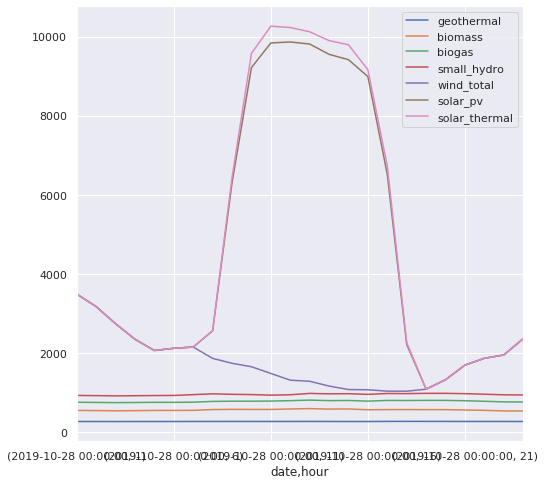

In [40]:
renewables = df5.copy()
renewables.pop('renewables')
renewables.pop('nuclear')
renewables.pop('thermal')
renewables.pop('imports')
renewables.pop('hydro')
renewables.pop('solar')
renewables.plot(figsize=(8,8), stacked=True)

### Problem 03 : How are these energy sources changing over time?

In [ ]:
# create the connection to the unzipped database in this directory
cnx = sqlite3.connect(r'./data-oasis-sld-ren-fcst-dam_00.db')

In [ ]:
# Read the database into a dataframe by joining report_header with report_data 
df1 = pd.read_sql("select report_data.trading_hub, report_data.renewable_type, report_data.data_item, report_data.value, report_header.uom, report_header.report, report_header.mkt_type, report_data.interval_start_gmt, report_data.interval_end_gmt from report_header inner join report_data on report_header.report_item_id = report_data.report_item_id;", cnx1)

# Convert gmt time strings to pandas datetime
df1['interval_start_ts'] = pd.to_datetime(df1['interval_start_gmt'])
df1['interval_end_ts'] = pd.to_datetime(df1['interval_end_gmt'])

# Drop unnec gmt columns
df1.drop(['interval_start_gmt', 'interval_end_gmt'], axis='columns', inplace=True)

# Set the index to be the start timestamp
df1 = df1.set_index('interval_start_ts', drop=True)
df1.head()

In [ ]:
df1.info()

In [ ]:
df1.trading_hub.unique()

In [ ]:
df1.renewable_type.unique()

In [ ]:
df1.mkt_type.unique()

In [ ]:
df1.data_item.unique()

In [ ]:
for title, group in df1.groupby(['renewable_type']):
    group.plot.line(y='value', title=title)

![Trading Hubs](./resources/images/caiso-regions.png)

In [ ]:
for title, group in df1.groupby(['trading_hub']):
    group.plot.line(y='value', title=title)


In [ ]:
### Renewables : Wind and Solar Summary

In [ ]:
# create the connection to the unzipped database in this directory
cnx2  = sqlite3.connect(r'./data-oasis-ene-wind-solar-summary_00.db')

In [ ]:
# read the database into a dataframe by joining report_header with report_data 
df2 = pd.read_sql("select report_data.data_item, report_data.value, report_header.uom, report_header.report, report_header.mkt_type, report_data.interval_start_gmt, report_data.interval_end_gmt from report_header inner join report_data on report_header.report_item_id = report_data.report_item_id;", cnx2)

# convert gmt time strings to pandas datetime
df2['interval_start_ts'] = pd.to_datetime(df2['interval_start_gmt'])
df2['interval_end_ts'] = pd.to_datetime(df2['interval_end_gmt'])

# drop unnec gmt columns
df2.drop(['interval_start_gmt', 'interval_end_gmt'], axis='columns', inplace=True)

# set the index to be the start timestamp
df2 = df2.set_index('interval_start_ts', drop=True)
df2.head()

In [ ]:
df2.info()

In [ ]:
df2.data_item.unique()

In [ ]:
for title, group in df2.groupby(['data_item']):
    group.plot.line(y='value', title=title)

## Data Items Explained

### DAM : Day Ahead Market

http://www.ercot.com/mktinfo/dam/

    Day-Ahead Market

    The Day-Ahead Market (DAM) is a voluntary, financially-binding forward energy market. The DAM matches willing buyers and sellers, subject to network security and     other constraints, whereby energy is co-optimized with Ancillary Services and certain Congestion Revenue Rights. It provides a platform to hedge congestion costs in the day-ahead of the Operating Day, and instruments to mitigate the risk of price volatility in Real-Time.


### RTM : Real Time Market

http://www.ercot.com/mktinfo/rtm

    Real-Time Market

    During real-time, ERCOT dispatches resources based on economics and reliability to meet the system demand while observing resource and transmission constraints. Security Constrained Economic Dispatch (SCED) is the real-time market evaluation of offers to produce a least-cost dispatch of online resources. SCED calculates Locational Marginal Prices (LMPs) using a two-step methodology that applies mitigation to resolve non-competitive constraints.

### RTD : Real Time Dispatch

## Links

* [Daily Renewables Watch](http://content.caiso.com/green/renewrpt/DailyRenewablesWatch.pdf)
* [CAISO Interface Specification](http://www.caiso.com/Documents/OASIS-InterfaceSpecification_v5_1_8Clean_Independent2019Release.pdf#search=Interface%20Specification)
* [Wind Solar RTD & Curtailment](http://www.caiso.com/Documents/Wind_SolarReal-TimeDispatchCurtailmentReportOct21_2019.pdf#search=Real%20Time%20Dispatch)
* [Daily Renewables Watch (local)](./resources/docs/DailyRenewablesWatch.pdf)
* [CAISO Interface Specification (local)](./resources/docs/OASIS-InterfaceSpecification_v5_1_8Clean_Independent2019Release.pdf)
* [Wind Solar RTD & Curtailment (local)](./resources/docs/Wind_SolarReal-TimeDispatchCurtailmentReportOct21_2019.pdf)